# Mobilenet on RESISC dataset

Mount google drive to download the dataset and unzip the data file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/AI project dataset.zip'
extract_dir = 'AI datasets' 

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        zip_ref.extract(file, extract_dir)

print("Extraction complete. Check the folder:", extract_dir)


Extraction complete. Check the folder: AI datasets


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root='/content/AI datasets/RESISC45/NWPU-RESISC45/', transform=data_transforms)

In [ ]:
train_size = int(0.7 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

In [ ]:
batch_size = 64
learning_rate = 0.001
num_epochs = 40

print(f"Training with batch size: {batch_size}, learning rate: {learning_rate}, and epochs: {num_epochs}")


Training with batch size: 64, learning rate: 0.001, and epochs: 40


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = models.mobilenet_v2(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 45)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
loss_during_epoch = []
accuracy_during_epoch = []


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1)

        self.model.zero_grad()
        output[:, target_class].backward(retain_graph=True)

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        return cam

def visualize_gradcam(cam, original_image, alpha=0.5):
    cam = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(original_image / 255)
    overlay = overlay / np.max(overlay)
    return np.uint8(255 * overlay)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1, Loss: 2.689556903078936, Accuracy: 24.46%, Validation Loss: 2.62380868497521, Validation Accuracy: 29.54%, Running time: 197.37644267082214


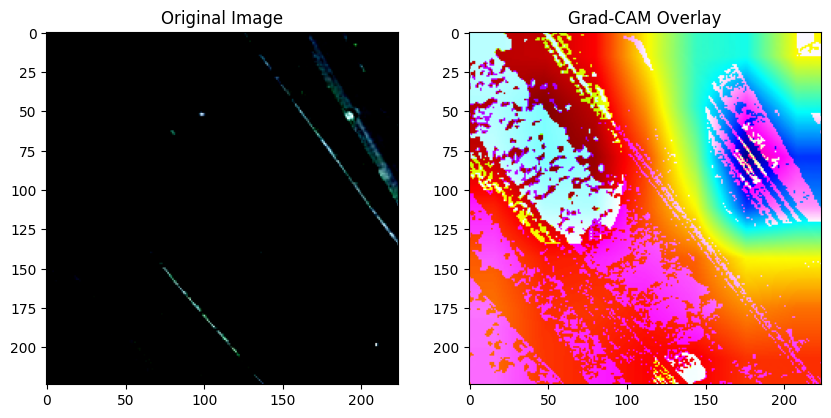

Epoch 2, Loss: 1.9486245663269706, Accuracy: 42.50%, Validation Loss: 1.7775457134150496, Validation Accuracy: 47.10%, Running time: 178.47935819625854


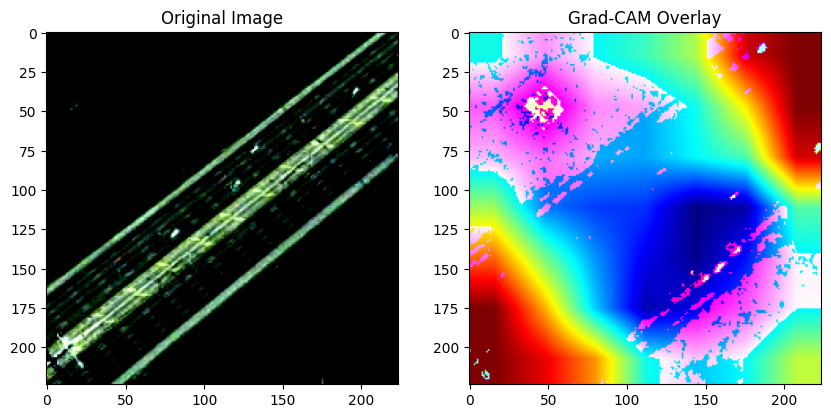

Epoch 3, Loss: 1.5670545305030934, Accuracy: 53.40%, Validation Loss: 1.6581465872851284, Validation Accuracy: 51.57%, Running time: 171.00020003318787


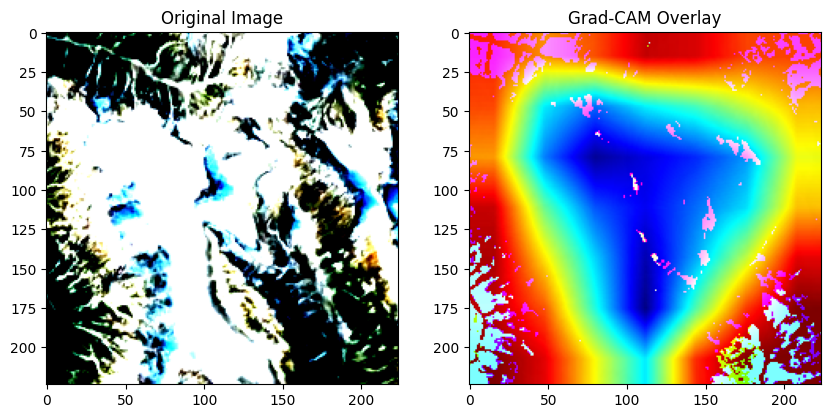

Epoch 4, Loss: 1.3325367079264876, Accuracy: 59.85%, Validation Loss: 1.382296039600565, Validation Accuracy: 58.92%, Running time: 172.03546166419983


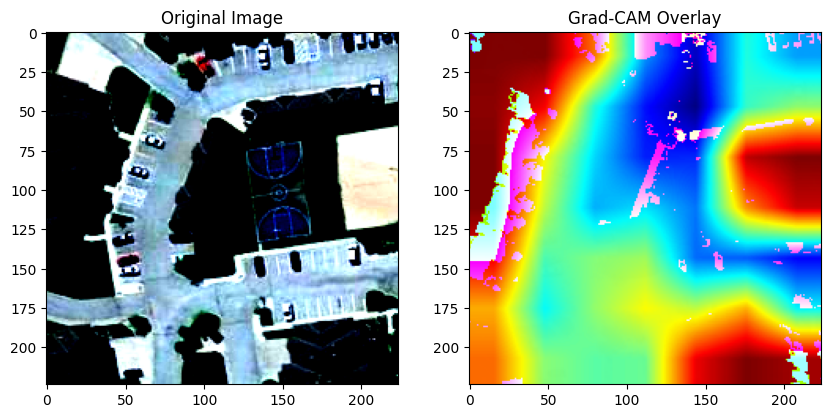

Epoch 5, Loss: 1.1127214151880016, Accuracy: 65.52%, Validation Loss: 1.357888030283379, Validation Accuracy: 60.33%, Running time: 172.13948941230774


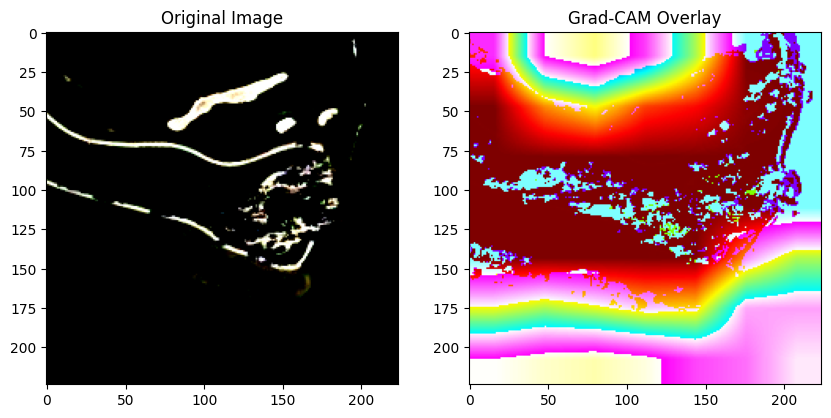

Epoch 6, Loss: 0.9416115420452063, Accuracy: 70.45%, Validation Loss: 1.3165767186819906, Validation Accuracy: 61.73%, Running time: 173.21826195716858


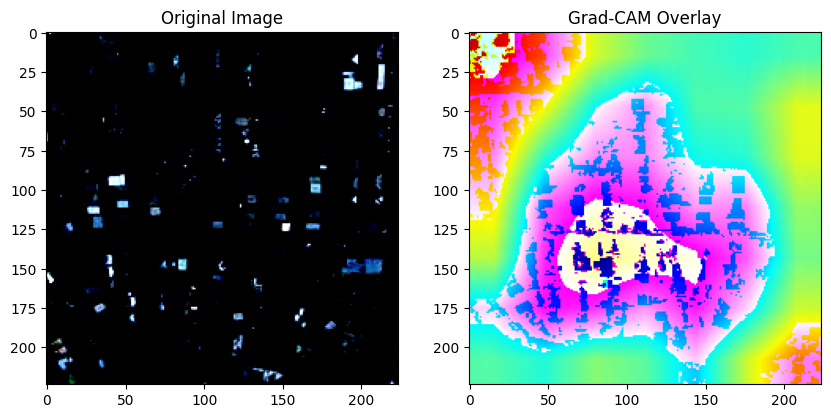

Epoch 7, Loss: 0.8095979560976443, Accuracy: 74.58%, Validation Loss: 1.324765149993126, Validation Accuracy: 63.75%, Running time: 171.19249939918518


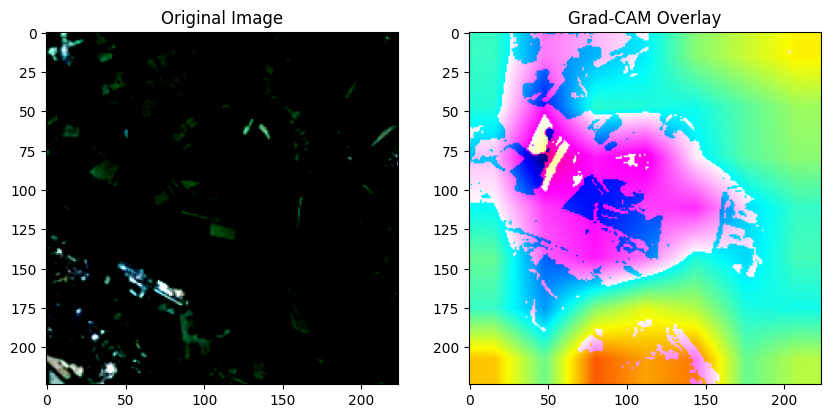

Epoch 8, Loss: 0.6995231134304102, Accuracy: 77.66%, Validation Loss: 0.9964295595583289, Validation Accuracy: 70.00%, Running time: 170.48767590522766


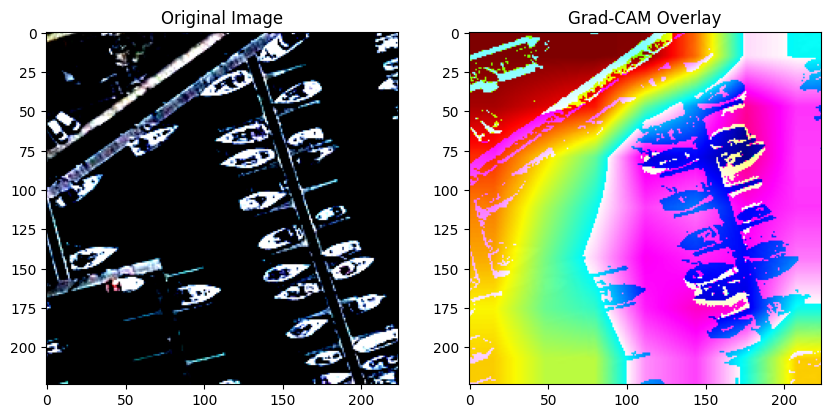

Epoch 9, Loss: 0.5983549269213193, Accuracy: 80.72%, Validation Loss: 0.9944639820041079, Validation Accuracy: 71.10%, Running time: 171.61191082000732


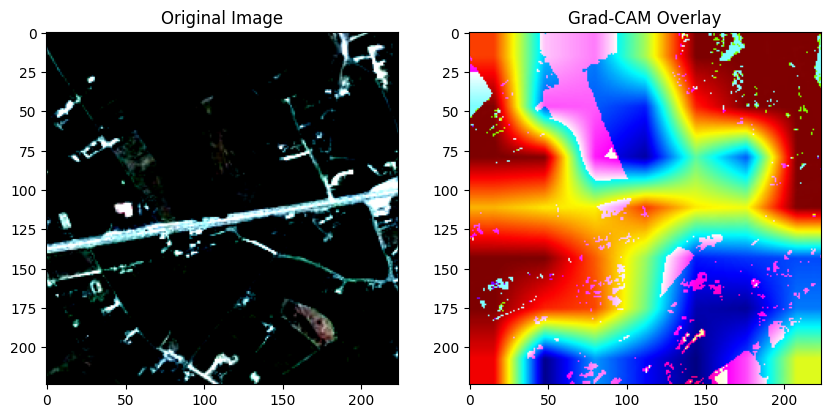

Epoch 10, Loss: 0.5269724054181057, Accuracy: 82.99%, Validation Loss: 0.9252729945712619, Validation Accuracy: 72.21%, Running time: 171.92528247833252


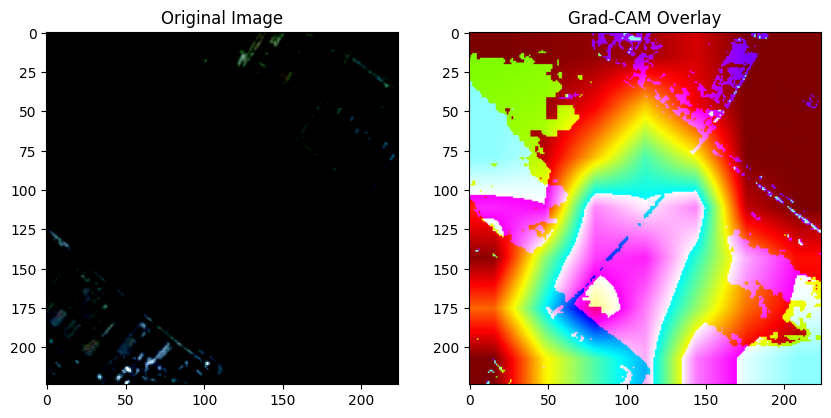

Epoch 11, Loss: 0.4576734411975612, Accuracy: 85.01%, Validation Loss: 0.9047788345452511, Validation Accuracy: 73.56%, Running time: 172.19972109794617


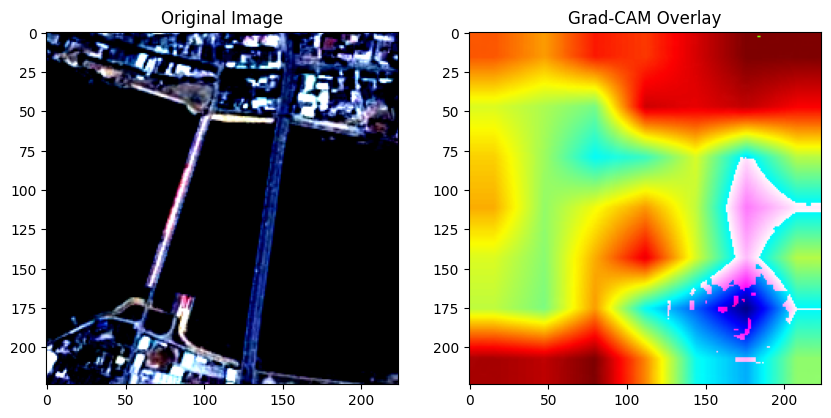

Epoch 12, Loss: 0.4079067995366843, Accuracy: 86.68%, Validation Loss: 1.2648361222912567, Validation Accuracy: 67.78%, Running time: 171.23616123199463


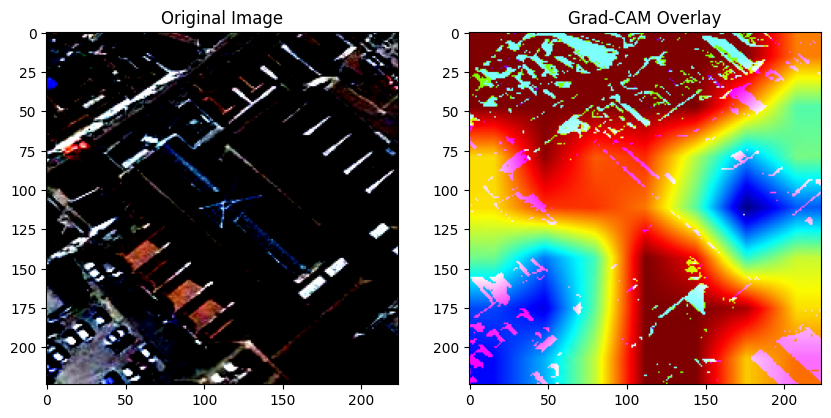

Epoch 13, Loss: 0.37106960973014, Accuracy: 88.00%, Validation Loss: 0.9519579455708013, Validation Accuracy: 73.90%, Running time: 172.52857899665833


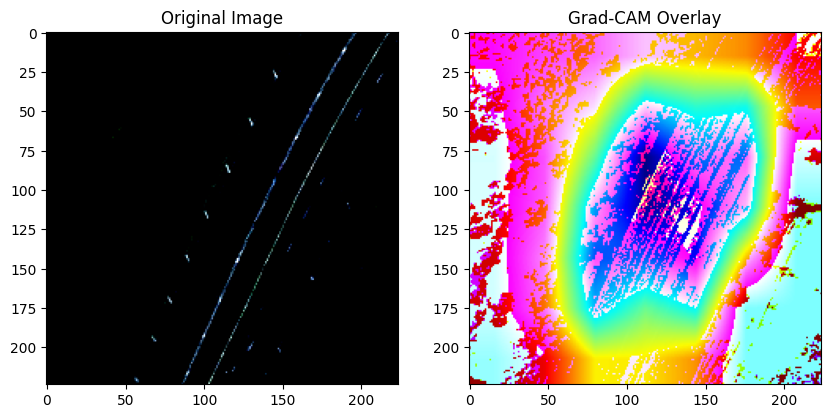

Epoch 14, Loss: 0.30897482495377027, Accuracy: 89.76%, Validation Loss: 0.8967810544100675, Validation Accuracy: 75.60%, Running time: 171.87744212150574


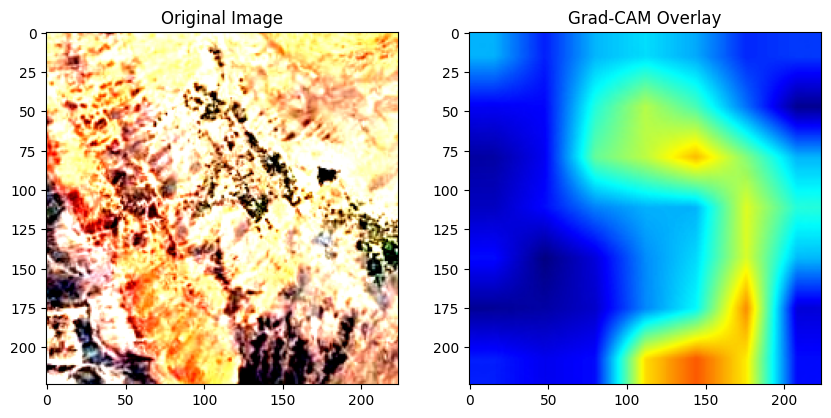

Epoch 15, Loss: 0.29229654097470686, Accuracy: 90.22%, Validation Loss: 0.953904283769203, Validation Accuracy: 74.13%, Running time: 171.8165066242218


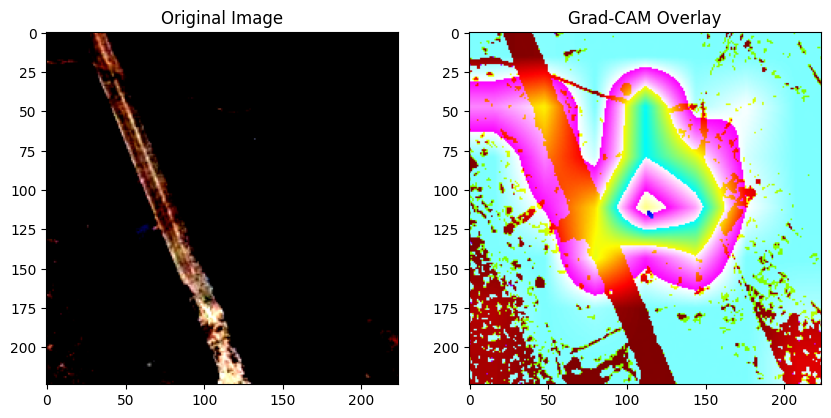

Epoch 16, Loss: 0.243719412462003, Accuracy: 91.89%, Validation Loss: 0.9317430369179658, Validation Accuracy: 75.94%, Running time: 171.9556849002838


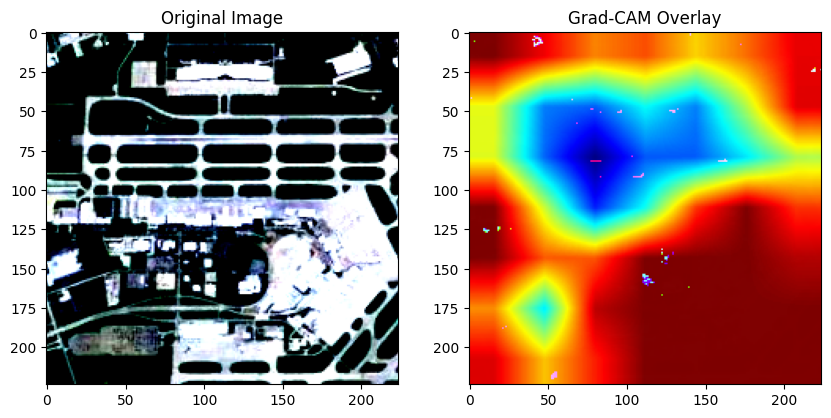

Epoch 17, Loss: 0.24206584875566373, Accuracy: 91.83%, Validation Loss: 0.8509088546940775, Validation Accuracy: 76.98%, Running time: 170.71358180046082


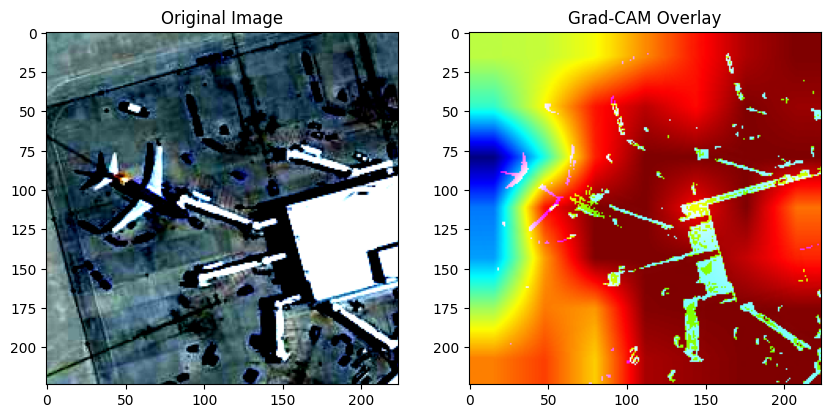

Epoch 18, Loss: 0.21126765348557114, Accuracy: 92.82%, Validation Loss: 1.030447578189349, Validation Accuracy: 74.30%, Running time: 171.0129337310791


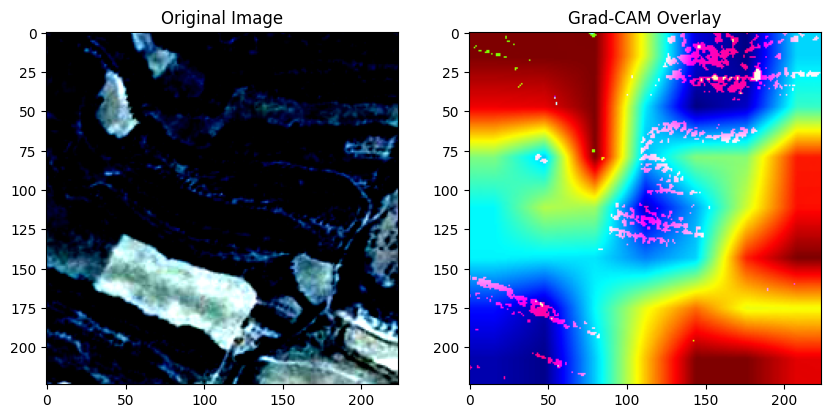

Epoch 19, Loss: 0.1926174683091433, Accuracy: 93.47%, Validation Loss: 0.9149715406726106, Validation Accuracy: 77.68%, Running time: 171.23254346847534


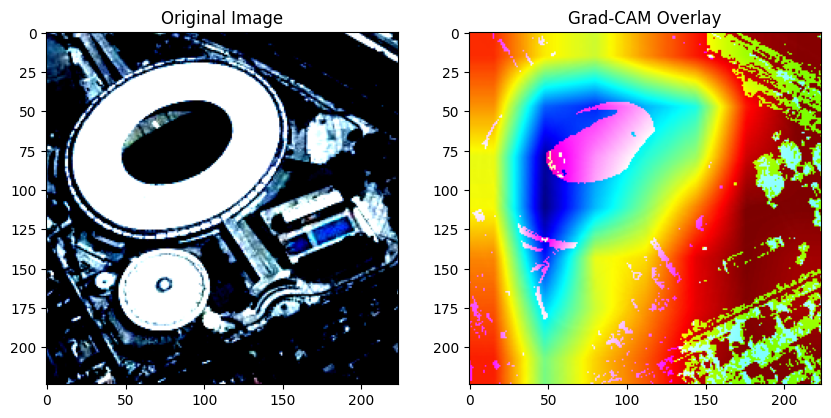

Epoch 20, Loss: 0.18161743104025938, Accuracy: 94.11%, Validation Loss: 1.0773599596336634, Validation Accuracy: 73.63%, Running time: 171.6264147758484


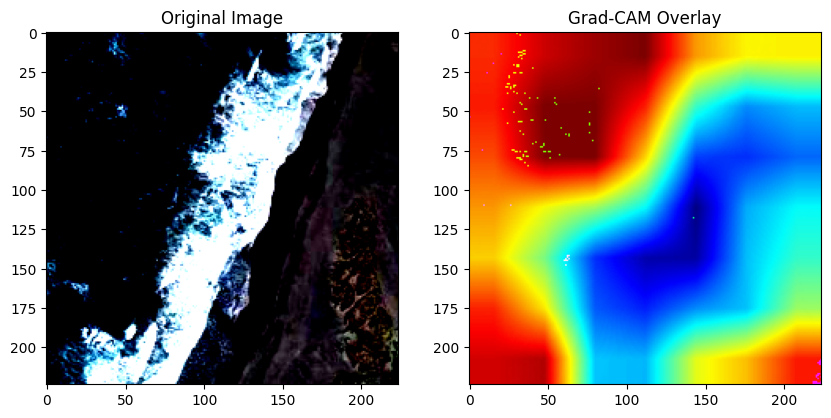

Epoch 21, Loss: 0.18869719433503737, Accuracy: 93.71%, Validation Loss: 0.9725989184596322, Validation Accuracy: 76.78%, Running time: 171.1713216304779


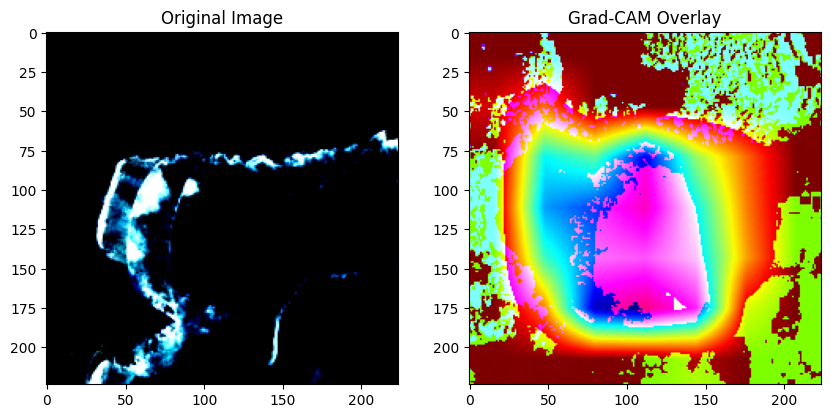

Epoch 22, Loss: 0.16274728481860265, Accuracy: 94.41%, Validation Loss: 0.9423661406594094, Validation Accuracy: 78.52%, Running time: 170.91969084739685


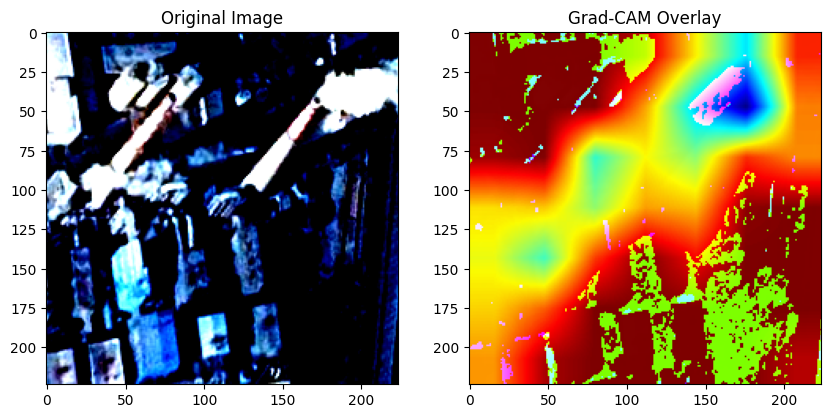

Early stopping!
Training stopped due to early stopping.


In [ ]:
patience = 5
best_valid_loss = float('inf')
epochs_no_improve = 0
early_stopping = False

train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    model.eval()
    valid_loss = 0.0
    valid_correct_predictions = 0
    valid_total_predictions = 0

    with torch.no_grad():
        for valid_inputs, valid_labels in valid_loader:
            valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
            valid_outputs = model(valid_inputs)
            valid_loss += criterion(valid_outputs, valid_labels).item()

            _, valid_predicted = torch.max(valid_outputs, 1)
            valid_correct_predictions += (valid_predicted == valid_labels).sum().item()
            valid_total_predictions += valid_labels.size(0)

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = valid_correct_predictions / valid_total_predictions

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    valid_loss_list.append(valid_loss)
    valid_accuracy_list.append(valid_accuracy)

    print(f"Epoch {epoch+1}, Loss: {train_loss}, Accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy * 100:.2f}%, "
          f"Running time: {elapsed_time}")

    sample_inputs, sample_labels = next(iter(valid_loader))
    sample_inputs = sample_inputs.to(device)
    original_image = sample_inputs[0].permute(1, 2, 0).cpu().numpy()  

    cam = gradcam.generate_cam(sample_inputs[0].unsqueeze(0))  
    overlay_image = visualize_gradcam(cam, original_image)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Overlay")
    plt.imshow(overlay_image)
    plt.show()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping!")
            early_stopping = True
            break

if early_stopping:
    print("Training stopped due to early stopping.")
else:
    print("Training completed all epochs.")
